# New Project Pivot:

Description: Weather app + predictors based on climate change history

My part: making visualizations based on previous weather data from Nasa API


## use aiohttp using async io

In [1]:
import numpy as np
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import express as px
import plotly.graph_objs as go
import matplotlib.dates as mdates
# ML libraries - idk which one to use yet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, r2_score
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import preprocessing, tree
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import cKDTree


# How does the NASA API call work?

NASA Power API Documentation can be found here: https://power.larc.nasa.gov/docs/services/api/

To get the weather data needed for this app, we use the temporal API from NASA Power (Prediction of Worldwide Energy Sources). This provides accurate weather and climate data from NASA's satellites, and can be requested daily or hourly.

How this API works is that you send a request to NASA's servers and they return the paramaters you ask for in a JSON format that we can use for our data visualizations and model later on. In the request, you need to specify your location (latitude and longitude), the time period (choosing between daily, hourly, or long-term averages), the weather parameters you want, and the format (here we chose JSON). 

We first identified what parameters we wanted to use throughout our project by looking at the parameter dictionary. 

Parameter Dictionary can be found here: https://power.larc.nasa.gov/docs/tutorials/parameters/

We turned this into an API call that we can use to call for any location and time in our app. When the user inputs their location on the map, the map sends the coordinates to our API function, which then finds the data for the paramaters we requested. This information is then used in our visualizations.

# How does aiohttp and asyncio work?

If you want to learn more about aiohttp and asyncio:
- aiohttp Documentation: https://docs.aiohttp.org/en/stable/
- asyncio Documentation: https://docs.python.org/3/library/asyncio.html

When making API requests, you usually use 'requests.get', which waits for each request to finish before requesting the next one. We decided to use aiohttp and asyncio to fetch multiple requests simultaneously because requesting weather data from each coordinate one by one took too long. This made making each visualization much faster from the requested data.

### What is asyncio?
asyncio is a Python library for running asynchronous tasks. It allows multiple tasks to run at the same time. It can work for API requests (what we are using it for) or for downloading files. 

Basic rundown of how to use:
1. `async def` -> defines the function (task) you want to do
2. `await` -> tells Python to wait for a task before continuing
3. `asyncio.gather()`-> runs multiple tasks at the same time

### What is aiohttp?
aiohttp works with asyncio to send multiple requests at the same time, this makes fetching API data faster because they all run at the same time. It replaces 'requests.get() for async operations. 

Basic rundown of how to use:
1. `aiohttp.ClientSession()` -> open a session to send requests
2. `async with session.get(url) as response` -> Fetches API data asynchronously
3. `await response.json()` -> waits for API response and converts it to JSON

In [2]:
# run this to install aiohttp 
# "pip install aiohttp"

In [3]:
import numpy as np
import aiohttp
import asyncio
import pandas as pd
import nest_asyncio
import plotly.express as px
from datetime import datetime

# Apply nest_asyncio for async execution 
nest_asyncio.apply()

async def fetch_nasa_data(session, lat, lon, start_date, end_date, sem):
    """
    Fetches hourly weather data from the NASA POWER API asynchronously for a given location and time range.
    """
    url = "https://power.larc.nasa.gov/api/temporal/hourly/point"
    parameters = "PRECSNO,T2MDEW,PRECTOTCORR,T2M,WS2M"

    params = {
        "parameters": parameters,
        "community": "RE",
        "longitude": lon,
        "latitude": lat,
        "start": start_date,
        "end": end_date,
        "format": "JSON"
    }

    async with sem:  
        async with session.get(url, params=params) as response:
            if response.status != 200:
                print(f"Error {response.status} for {lat}, {lon}, {start_date}-{end_date}")
                return None
            return await response.json()  

async def get_nasa_power_hourly_data(lat, lon, date=None):
    """
    Fetches NASA POWER hourly weather data for a single day (default behavior).
    """
    if date is None:
        date = datetime.now().strftime("%Y%m%d")

    sem = asyncio.Semaphore(5)
    async with aiohttp.ClientSession() as session:
        data = await fetch_nasa_data(session, lat, lon, date, date, sem)

    if data is None or "properties" not in data:
        print(f"No data found for {lat}, {lon} on {date}")
        return None

    df = pd.DataFrame.from_dict(data["properties"]["parameter"], orient="index").T
    df.reset_index(inplace=True)
    df.rename(columns={"index": "datetime"}, inplace=True)
    
    # Convert datetime and clean up
    df["datetime"] = pd.to_datetime(df["datetime"], format="%Y%m%d%H", errors="coerce")
    df.dropna(subset=["datetime"], inplace=True)
    
    # Rename columns
    df.rename(columns={
        "PRECSNO": "Snow_Precipitation",
        "T2MDEW": "Dew_Point_2m",
        "PRECTOTCORR": "Total_Precipitation_mm",
        "T2M": "Temperature_2m_C",
        "WS2M": "Wind_Speed_2m"
    }, inplace=True)

    # Add Lat/Lon
    df["Latitude"] = lat
    df["Longitude"] = lon

    # Convert units
    df["Precipitation(in)"] = df["Total_Precipitation_mm"] / 25.4  
    df["Temperature(F)"] = (df["Temperature_2m_C"] * 9/5) + 32  
    df["Wind_Speed(mph)"] = df["Wind_Speed_2m"] * 2.237  

    return df

async def get_nasa_power_hourly_data_years(lat, lon, start_year, end_year):
    """
    Fetches NASA POWER API hourly data for multiple years in 2-year chunks to prevent timeouts.
    """
    tasks = []
    
    for year in range(start_year, end_year):  
        start_date = f"{year}0101"
        end_date = f"{min(year, end_year)}1231"
        print(f"Fetching data from {start_date} to {end_date} for {lat}, {lon}")
        tasks.append(get_nasa_power_hourly_data(lat, lon, start_date))

    results = await asyncio.gather(*tasks)

    all_data = [df for df in results if df is not None]

    return pd.concat(all_data, ignore_index=True) if all_data else None



# Making visualizations

I used the Plotly library to visualize weather data retrieved from the NASA POWER API.  

For the visualizations, I created plots showing hourly updates for temperature, precipitation, and wind speed for the user-selected location. I used the `get_nasa_power_hourly_data(lat, lon, specific_date)` function to retrieve the necessary data. This function allowed me to obtain the parameters for a specific day at the chosen location.  

I also created a visualization displaying weather trends over the past ten years. To make the data more readable, I calculated the mean values for precipitation, temperature, and wind speed. To implement this, I created a new API function call: `get_nasa_power_hourly_data_years(lat, lon, start_year, end_year)`. This function retrieves two years of data at a time because requesting too many years from the NASA POWER API at once caused timeouts.  

Lastly, I created a visualization using Plotly’s choropleth map to display precipitation and temperature at random locations within a radius of the user’s selected location. I chose this approach because generating a heatmap required making API requests for every coordinate, which was not feasible. To implement this, I created a new API function. The `get_nasa_power_data_for_one_day_nearby()` function fetches weather parameters for nearby locations after the `generate_new_locations()` function generates a set of coordinates within a 15-mile radius of the user’s chosen location.

In [4]:
def plot_hourly_temperature(df):
    """
    Plots hourly temperature trends for one day.
    """
    fig = px.line(df, x="datetime", y="Temperature(F)", 
                  title="Hourly Temperature Trends",
                  labels={"datetime": "Datetime", "Temperature(F)": "Temperature (°F)"},
                  line_shape='linear', color_discrete_sequence=['red'])

    fig.update_layout(xaxis_title="Datetime", yaxis_title="Temperature (°F)", xaxis_tickangle=-45)
    fig.show()

def plot_hourly_precipitation(df):
    """
    Plots hourly precipitation trends for one day.
    """
    fig = px.line(df, x="datetime", y="Precipitation(in)", 
                  title="Hourly Precipitation Trends",
                  labels={"datetime": "Datetime", "Precipitation(in)": "Total Precipitation (in)"},
                  line_shape='linear', color_discrete_sequence=['blue'])

    fig.update_layout(xaxis_title="Datetime", yaxis_title="Precipitation (in)", xaxis_tickangle=-45)
    fig.show()

def plot_hourly_wind_speed(df):
    """Plot wind speed trends over time using Plotly."""
    fig = px.line(df, x="datetime", y="Wind_Speed_2m", title="Hourly Wind Speed Trends",
                  labels={"datetime": "Datetime", "Wind_Speed_2m": "Wind Speed (m/s)"},
                  line_shape='linear', color_discrete_sequence=['green'])
    fig.update_layout(xaxis_title="Datetime", yaxis_title="Wind Speed (m/s)", xaxis_tickangle=-45)
    fig.show()


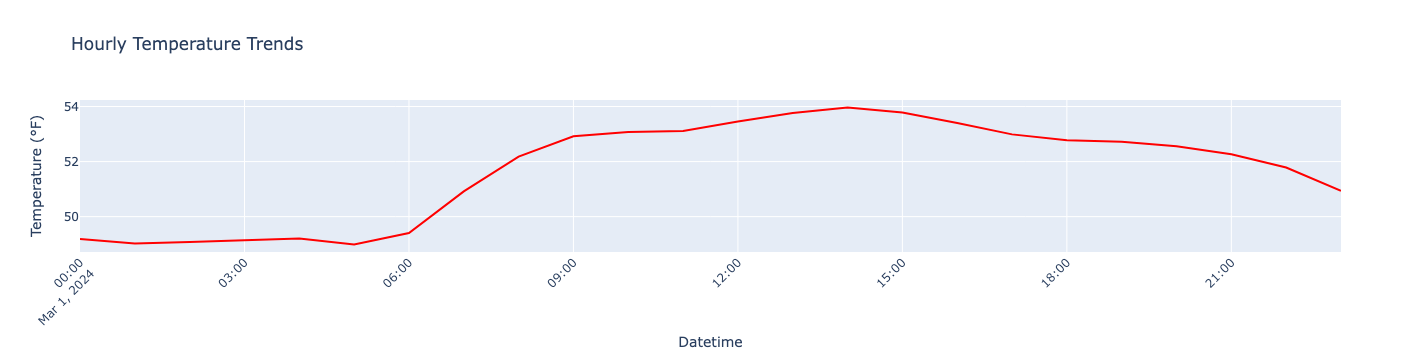

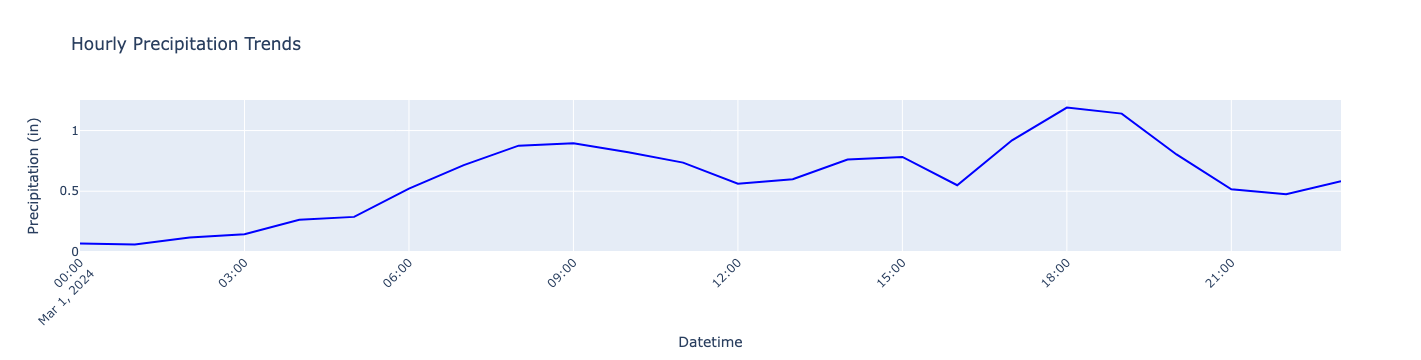

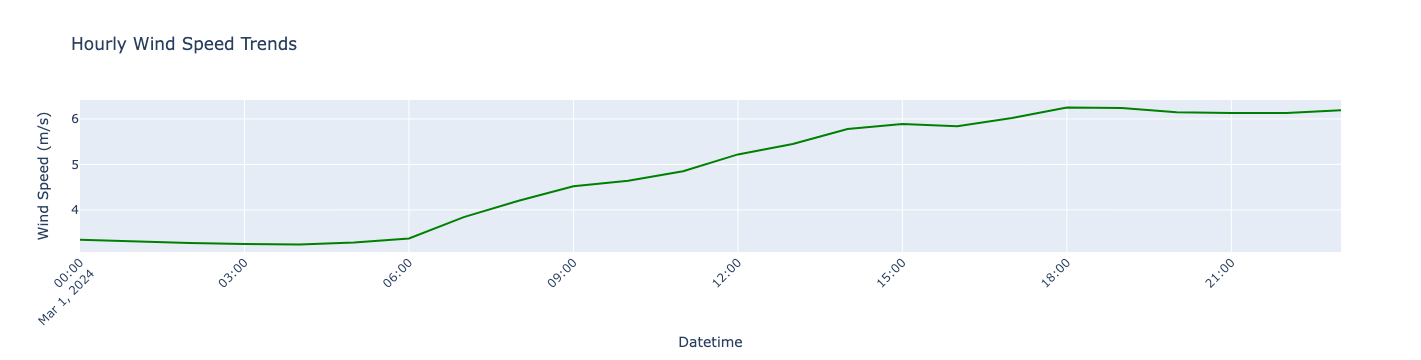

In [5]:
lat, lon = 37.7749, -122.4194  # San Francisco
specific_date = "20240301"  # Example: March 1, 2024

df_one_day = await get_nasa_power_hourly_data(lat, lon, specific_date)

if df_one_day is not None:
    plot_hourly_temperature(df_one_day)
    plot_hourly_precipitation(df_one_day)
    plot_hourly_wind_speed(df_one_day)

In [6]:
def plot_yearly_temperature(df):
    """
    Plot yearly mean temperature trends 
    Args:
        df: the dataframe from the NASA API call
    """
    df["year"] = df["datetime"].dt.year
    yearly_means = df.groupby("year")["Temperature_2m_C"].mean().reset_index()
    fig = px.bar(yearly_means,
                 x="year",
                 y="Temperature_2m_C",
                 color_discrete_sequence=["pink"],
                 title="Yearly Average Temperature Trends",
                 labels={"year": "Year", "Temperature_2m_C": "Mean Temperature (°C)"})
    fig.show()

def plot_yearly_precipitation(df):
    """
    Plot yearly mean precipitation trends.
    Args:
        df: the dataframe from the NASA API call
    """
    df["year"] = df["datetime"].dt.year
    yearly_means = df.groupby("year")["Total_Precipitation_mm"].mean().reset_index()
    fig = px.bar(yearly_means, x="year",
                 y="Total_Precipitation_mm",
                 color_discrete_sequence=["blue"],
                 title="Yearly Average Precipitation Trends",
                 labels={"year": "Year", "Total_Precipitation_mm": "Mean Precipitation (mm)"})
    fig.show()

def plot_yearly_wind_speed(df):
    """
    Plot yearly mean wind speed trends.
    Args:
        df: the dataframe from the NASA API call
    """
    df["year"] = df["datetime"].dt.year
    yearly_means = df.groupby("year")["Wind_Speed_2m"].mean().reset_index()
    fig = px.bar(yearly_means, 
                 x="year",
                 y="Wind_Speed_2m", 
                 color_discrete_sequence=["green"],
                 title="Yearly Average Wind Speed Trends", 
                 labels={"year": "Year", "Wind_Speed_2m": "Mean Wind Speed (m/s)"})
    fig.show()


Fetching data from 20140101 to 20141231 for 37.7749, -122.4194
Fetching data from 20150101 to 20151231 for 37.7749, -122.4194
Fetching data from 20160101 to 20161231 for 37.7749, -122.4194
Fetching data from 20170101 to 20171231 for 37.7749, -122.4194
Fetching data from 20180101 to 20181231 for 37.7749, -122.4194
Fetching data from 20190101 to 20191231 for 37.7749, -122.4194
Fetching data from 20200101 to 20201231 for 37.7749, -122.4194
Fetching data from 20210101 to 20211231 for 37.7749, -122.4194
Fetching data from 20220101 to 20221231 for 37.7749, -122.4194
Fetching data from 20230101 to 20231231 for 37.7749, -122.4194
Error 502 for 37.7749, -122.4194, 20200101-20200101
No data found for 37.7749, -122.4194 on 20200101


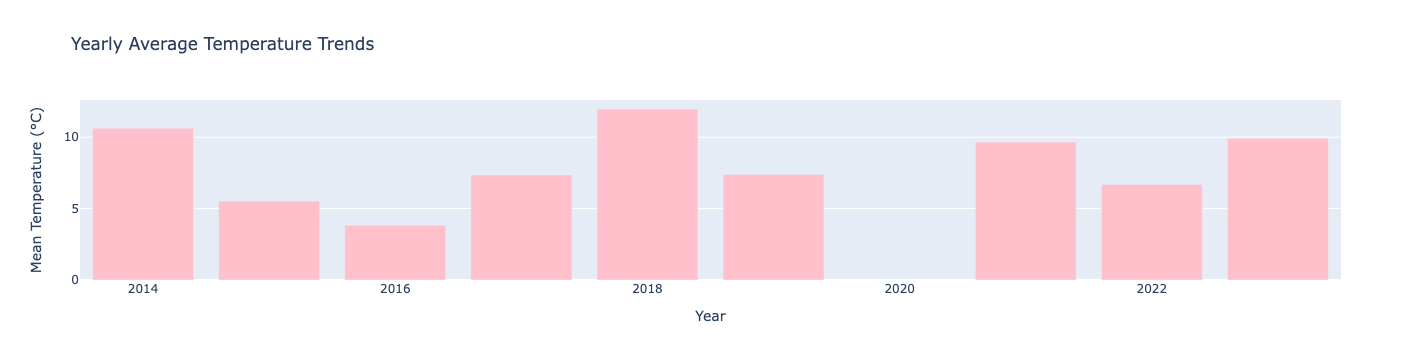

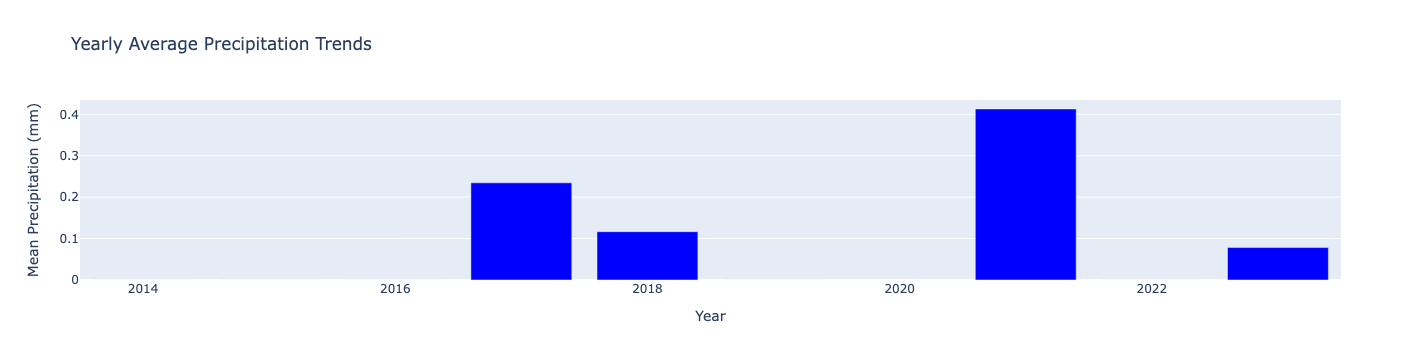

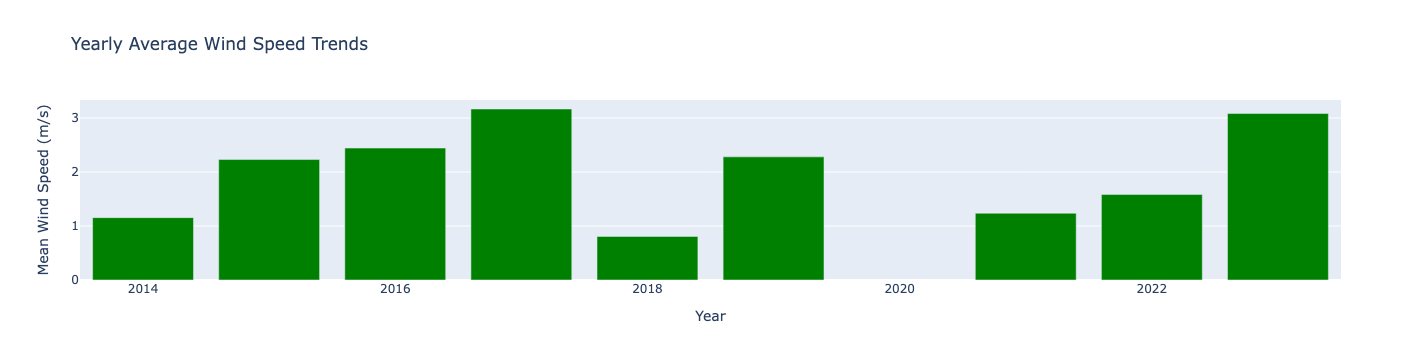

In [7]:
# plot temperature trends for last ten years
lat, lon = 37.7749, -122.4194  # San Francisco
start_year, end_year = 2014, 2024

df_ten_years = await get_nasa_power_hourly_data_years(lat, lon, start_year, end_year)

if df_ten_years is not None:
        plot_yearly_temperature(df_ten_years)
        plot_yearly_precipitation(df_ten_years)
        plot_yearly_wind_speed(df_ten_years)

In [8]:
def generate_nearby_locations(lat, lon, radius_miles=15, num_points=10):
    """
    Generates random nearby locations within a radius using NumPy.

    Args:
    - lat (float): Latitude of the center point.
    - lon (float): Longitude of the center point.
    - radius_miles (float): Search radius in miles.
    - num_points (int): Number of locations to generate.

    Returns:
    - NumPy array of shape (num_points, 2) with latitude and longitude values.
    """
    # Generate random angles uniformly between 0 and 2π
    angles = np.random.uniform(0, 2 * np.pi, num_points)

    # Use square root scaling to distribute points uniformly across the circle
    distances = radius_miles * np.sqrt(np.random.uniform(0, 1, num_points))

    # Convert polar coordinates (distance, angle) to latitude & longitude offsets
    delta_lat = (distances / 69) * np.cos(angles)
    delta_lon = (distances / (69 * np.cos(np.radians(lat)))) * np.sin(angles)

    # Compute new latitudes and longitudes
    new_lat = lat + delta_lat
    new_lon = lon + delta_lon

    return np.column_stack((new_lat, new_lon))

In [9]:
async def get_nasa_power_data_for_one_day_nearby(lat, lon, date=None, num_locations=10, radius_miles=15):
    """
    Fetches NASA POWER API hourly data for multiple nearby locations for a single day.

    Args:
        lat (float): Latitude of the central location.
        lon (float): Longitude of the central location.
        date (str, optional): Date in "YYYYMMDD" format. Defaults to today.
        num_locations (int, optional): Number of nearby locations to generate. Default is 10.
        radius_miles (float, optional): Radius in miles to generate nearby locations. Default is 15.

    Returns:
        pd.DataFrame or None: A Pandas DataFrame containing weather data for all locations, or None if no data is retrieved.
    """
    if date is None:
        date = datetime.now().strftime("%Y%m%d")

    locations = generate_nearby_locations(lat, lon, radius_miles, num_locations)
    tasks = [get_nasa_power_hourly_data(location[0], location[1], date) for location in locations]

    results = await asyncio.gather(*tasks)

    all_data = [df for df in results if df is not None]

    return pd.concat(all_data, ignore_index=True) if all_data else None


In [10]:
def plot_heatmap(lat, lon, date=None, num_locations=50, radius_miles=15):
    """
    Fetches weather data for locations in a radius and plots temperature & precipitation heat maps
    with a square-shaped view.
    """
    locations = generate_nearby_locations(lat, lon, radius_miles, num_locations)
    
    # Fetch weather data
    weather_data = asyncio.run(get_nasa_power_data_for_one_day_nearby(lat, lon, date, num_locations, radius_miles))
    if weather_data is None or weather_data.empty:
        print("No data retrieved.")
        return

    # Force a square bounding box
    lat_margin = radius_miles / 69  # 1 degree latitude ≈ 69 miles
    lon_margin = radius_miles / (69 * np.cos(np.radians(lat)))  # Adjust for longitude shrinking

    min_lat, max_lat = lat - lat_margin, lat + lat_margin
    min_lon, max_lon = lon - lon_margin, lon + lon_margin

    fig_temp = px.scatter_mapbox(
        weather_data, lat="Latitude", lon="Longitude", color="Temperature(F)", size="Temperature(F)",
        title="Temperature (°F) in Nearby Locations"
    )
    fig_temp.update_layout(
        mapbox_style="carto-positron",
        autosize=True 
    )

    fig_precip = px.scatter_mapbox(
        weather_data, lat="Latitude", lon="Longitude", color="Precipitation(in)", size="Precipitation(in)",
        title="Precipitation (in) in Nearby Locations"
    )
    fig_precip.update_layout(
        mapbox_style="carto-positron",
        autosize=True,
    )

    fig_temp.show()
    fig_precip.show()


Error 502 for 33.95947700009424, -118.61872337589601, 20240301-20240301
No data found for 33.95947700009424, -118.61872337589601 on 20240301
Error 502 for 34.249953076078384, -118.48644678977372, 20240301-20240301
No data found for 34.249953076078384, -118.48644678977372 on 20240301


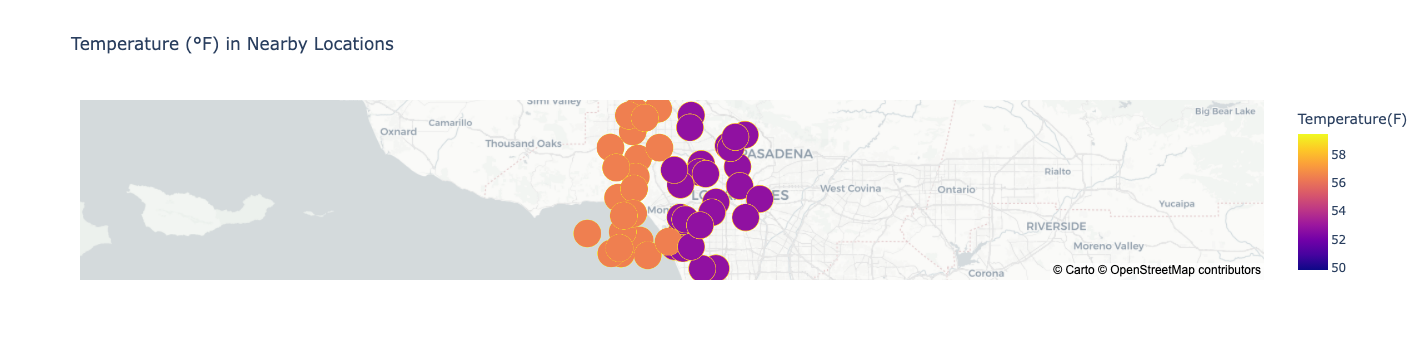

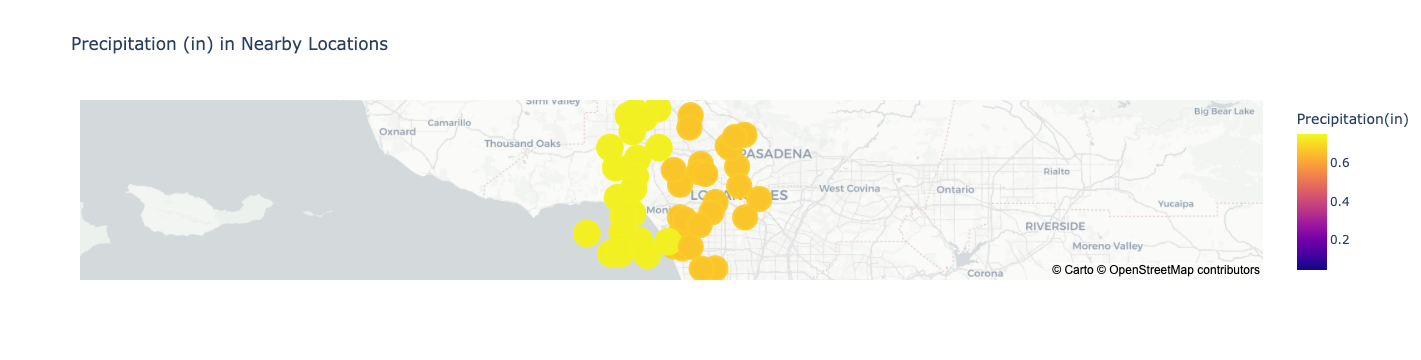

In [11]:
df_nearby_one_day = await get_nasa_power_data_for_one_day_nearby(34.0722, -118.4427, "20240301", num_locations=50)

plot_heatmap(34.0722, -118.4427, "20240301", num_locations=50)


Let me know if you have any questions calling it :)

# This doesn't work

I'm trying to get the geojson data to find the city coords for LA county but I think it is taking too long and won't run...

In [12]:
pip install geopandas 

Note: you may need to restart the kernel to use updated packages.


In [ ]:

import geopandas as gpd
import pandas as pd
import asyncio
import aiohttp
import plotly.express as px

# Load LA County Neighborhoods GeoJSON
geojson_url = "https://raw.githubusercontent.com/codeforgermany/click_that_hood/master/public/data/los-angeles-county.geojson"
la_county_geojson = gpd.read_file(geojson_url)

# Ensure data is in WGS84 before computing coordinates
if la_county_geojson.crs is None or la_county_geojson.crs.to_epsg() != 4326:
    la_county_geojson = la_county_geojson.to_crs(epsg=4326)

# Compute mean latitude and longitude instead of centroid
def calculate_mean_coordinates(geometry):
    """ Calculate the mean latitude and longitude for a given geometry. """
    coords = list(geometry.exterior.coords) if geometry.geom_type == "Polygon" else []
    if not coords:
        return None, None
    mean_lon = sum(x for x, y in coords) / len(coords)
    mean_lat = sum(y for x, y in coords) / len(coords)
    return round(mean_lat, 4), round(mean_lon, 4)

# Apply the function to extract mean coordinates
la_county_geojson["mean_coords"] = la_county_geojson.geometry.apply(calculate_mean_coordinates)

# Extract neighborhood coordinates as a dictionary
neighborhoods = {
    row["name"]: row["mean_coords"]
    for i, row in la_county_geojson.iterrows() if row["mean_coords"] != (None, None)
}

# Function to fetch NASA POWER API temperature data asynchronously
async def fetch_nasa_data(session, lat, lon, start_date, end_date, sem):
    url = "https://power.larc.nasa.gov/api/temporal/hourly/point"
    parameters = "T2M"

    params = {
        "parameters": parameters,
        "community": "RE",
        "longitude": lon,
        "latitude": lat,
        "start": start_date,
        "end": end_date,
        "format": "JSON"
    }

    async with sem:
        await asyncio.sleep(1)  # Add delay to prevent rate-limiting
        async with session.get(url, params=params) as response:
            if response.status != 200:
                print(f"Error {response.status} for {lat}, {lon}, {start_date}-{end_date}")
                return None
            return await response.json()

async def get_nasa_power_temperature(lat, lon, start_date, end_date, sem):
    """
    Fetches NASA POWER hourly weather data for a location and calculates the average temperature.
    """
    async with sem:  # Limit to 2 concurrent requests
        async with aiohttp.ClientSession() as session:
            data = await fetch_nasa_data(session, lat, lon, start_date, end_date, sem)

    if data is None or "properties" not in data:
        print(f"No data found for {lat}, {lon} on {start_date}")
        return None

    df = pd.DataFrame.from_dict(data["properties"]["parameter"], orient="index").T
    df["Temperature(F)"] = (df["T2M"] * 9/5) + 32  # Convert °C to °F
    return df["Temperature(F)"].mean()  # Return average temperature


async def fetch_neighborhood_temperatures():
    """
    Fetch temperature data for each neighborhood asynchronously, limited to 2 concurrent requests.
    """
    sem = asyncio.Semaphore(2)  # Limit concurrent requests to 2 at a time
    tasks = [get_nasa_power_temperature(lat, lon, "20240225", "20240225", sem) for name, (lat, lon) in neighborhoods.items()]
    
    results = await asyncio.gather(*tasks)

    neighborhood_temps = []
    for (name, (lat, lon)), temp in zip(neighborhoods.items(), results):
        if temp is not None:
            neighborhood_temps.append({"Neighborhood": name, "Latitude": lat, "Longitude": lon, "Temperature(F)": temp})

    return pd.DataFrame(neighborhood_temps)

async def plot_la_temperature_map():
    """
    Fetches data and plots a choropleth map of temperature data for neighborhoods in LA County.
    """
    df_temps = await fetch_neighborhood_temperatures()

    if df_temps.empty:
        print("No valid temperature data available.")
        return

    # Ensure the neighborhood names match between DataFrame and GeoJSON
    la_county_geojson["name"] = la_county_geojson["name"].str.strip()
    df_temps["Neighborhood"] = df_temps["Neighborhood"].str.strip()

    # Create a choropleth map
    fig = px.choropleth_mapbox(
        df_temps,
        geojson=la_county_geojson,
        locations="Neighborhood",
        featureidkey="properties.name",
        color="Temperature(F)",
        color_continuous_scale="thermal",
        hover_name="Neighborhood",
        mapbox_style="carto-positron",
        center={"lat": 34.05, "lon": -118.25},
        zoom=9,
        title="Los Angeles County Neighborhood Temperature Map"
    )

    fig.show()

# Run the function to generate the plot
await plot_la_temperature_map()


using https://data.lacounty.gov/datasets/lacounty::city-boundaries-lines/about

In [ ]:
'''
# Load the GeoJSON file
geojson_path = "City_Boundaries_Lines.geojson"
gdf = gpd.read_file(geojson_path)

# Compute centroid
gdf["centroid"] = gdf.geometry.centroid  

# Create a new table with city names and their centroid coordinates
city_coords_df = pd.DataFrame({
    # get city names, lat, long
    "city": gdf["CITY_NAME"], 
    "latitude": gdf["centroid"].y,  
    "longitude": gdf["centroid"].x 

print(city_coords_df.head())
'''


In [ ]:
'''
async def fetch_neighborhood_temperatures():
    """
    Fetch temperature data for each neighborhood asynchronously, limited to 2 concurrent requests.
    """
    sem = asyncio.Semaphore(2)  # Limit concurrent requests to 2 at a time
    tasks = [get_nasa_power_temperature(lat, lon, "20240225", "20240225", sem) for name, (lat, lon) in neighborhoods.items()]
    
    results = await asyncio.gather(*tasks)

    neighborhood_temps = []
    for (name, (lat, lon)), temp in zip(neighborhoods.items(), results):
        if temp is not None:
            neighborhood_temps.append({"Neighborhood": name, "Latitude": lat, "Longitude": lon, "Temperature(F)": temp})

    return pd.DataFrame(neighborhood_temps)

async def plot_la_temperature_map():
    """
    Fetches data and plots a choropleth map of temperature data for neighborhoods in LA County.
    """
    df_temps = await fetch_neighborhood_temperatures()

    if df_temps.empty:
        print("No valid temperature data available.")
        return

    # Ensure the neighborhood names match between DataFrame and GeoJSON
    la_county_geojson["name"] = la_county_geojson["name"].str.strip()
    df_temps["Neighborhood"] = df_temps["Neighborhood"].str.strip()

    # Create a choropleth map
    fig = px.choropleth_mapbox(
        df_temps,
        geojson=la_county_geojson,
        locations="Neighborhood",
        featureidkey="properties.name",
        color="Temperature(F)",
        color_continuous_scale="thermal",
        hover_name="Neighborhood",
        mapbox_style="carto-positron",
        center={"lat": 34.05, "lon": -118.25},
        zoom=9,
        title="Los Angeles County Neighborhood Temperature Map"
    )

    fig.show()
'''